# Müşteri Segmantasyonu

Buradaki veriler dağıtımcının yıllık bazda yaptığı satışları içerir. Channel ve Region değişkeni kategorik olup, satın alımın hangi kanal ve bölgeden yapıldığını belirtir. 

🎯 Amacımız, dağıtımcının müşteri profilini görmesi için, bir gözetimsiz öğrenme yöntemi olan kümeleme analizi ile müşterileri belli segmentlere ayırmaktır.

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree
from scipy.stats import skew, kurtosis, normaltest, shapiro, probplot, boxcox 


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Wholesale customers data.csv')
df = data.copy()
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


<div style="float: left;">

| Değişken            | Açıklama                                 | Veri Tipi |
|---------------------|-----------------------------------------|-----------|
| TAZE (Fresh)        | Taze ürünler için yıllık harcama        | Sürekli   |
| SÜT (Milk)          | Süt ürünlerine yapılan yıllık harcama    | Sürekli   |
| BAKKALİYE (Grocery) | Bakkaliye ürünlerine yapılan yıllık harcama | Sürekli   |
| DONDURULMUŞ (Frozen) | Dondurulmuş ürünler için yıllık harcama | Sürekli   |
| DETERJAN/KAĞIT (Detergent/Paper)    | Deterjan ve kağıt ürünleri için yıllık harcama | Sürekli   |
| ŞARKÜTERİ (Delicassen) | Şarküteri ürünlerinde yapılan yıllık harcama | Sürekli   |

Region ve Channel kategorik veriler olduğu için analize dahil etmeyeceğiz.

In [3]:
df.shape

(440, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [8]:
corr = df.corr()
corr

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


# 📊 EDA 

## Kategorik Veriler

### Channel Değişkeni
Channel, müşterilerin hangi kanallar vasıtasıyla satın alım yaptıklarını belirtir. Bunlar Otel/Restoran/Kafe veya Perakende kanalları olabilir. Değişkenin tipi kategoriktir.

2 adet unique değer vardır. Ağırlık **1** olarak kodlanan kanaldan yanadır. Dağılımın dengesiz olduğu söylenebilir.

In [9]:
df['Channel'].unique()

array([2, 1], dtype=int64)

1    298
2    142
Name: Channel, dtype: int64

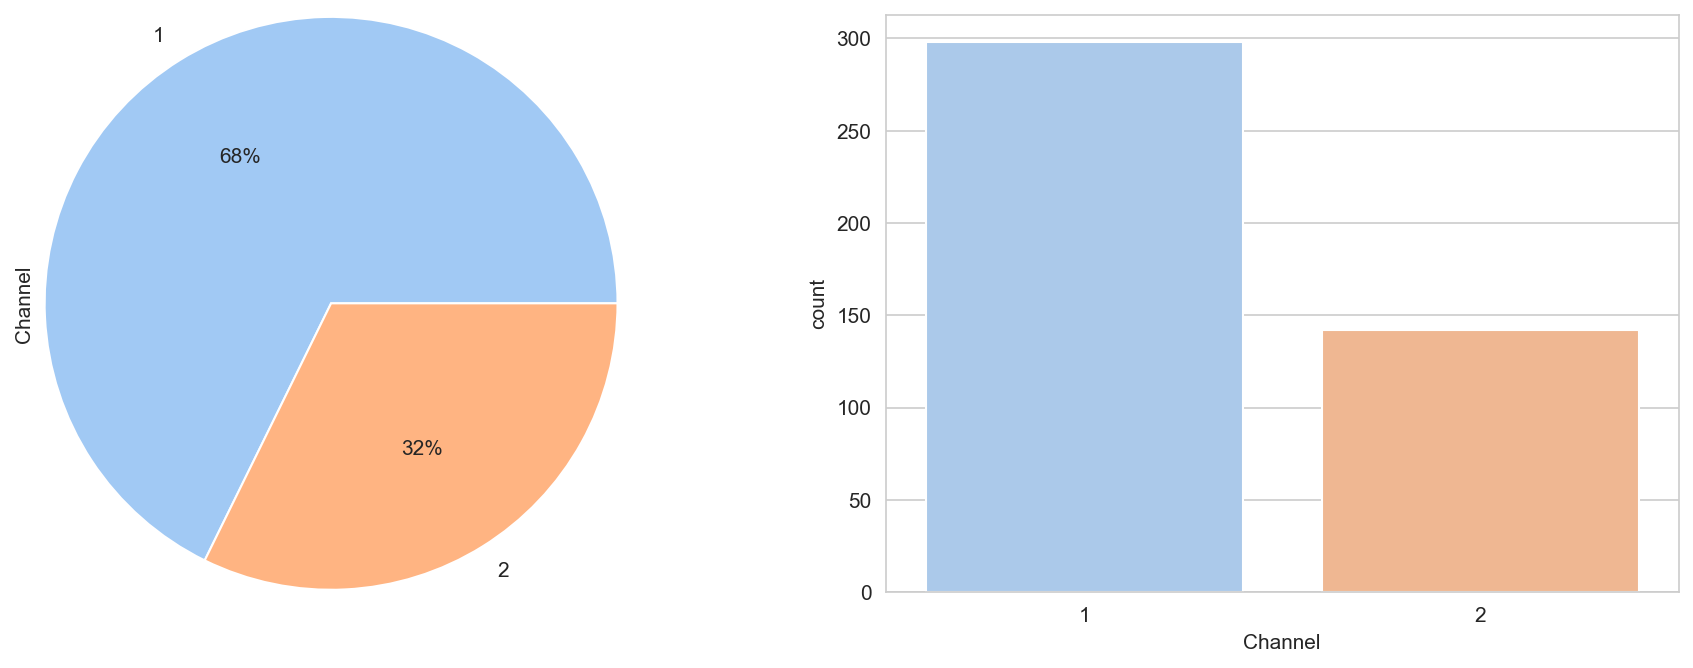

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5), dpi=150)
plt.subplot(121)
df['Channel'].value_counts().plot(kind='pie', autopct='%2.f%%', radius=1.24, colors=sns.color_palette('pastel'))
plt.subplot(122)
sns.countplot(data=df, x='Channel', palette='pastel')
df['Channel'].value_counts()

### Region Değişkeni
Channel, müşterilerin hangi bölgelerden satın alım yaptığını belirtir. Bunlar İstanbul/İzmir/Ankara olabilir. Değişkenin tipi kategoriktir.

3 adet unique değer vardır. Ağırlık **3** olarak kodlanan bölgeden yanadır. Buradaki dengesizlik Channel değişkenine göre daha fazladır.

In [11]:
df['Region'].unique()

array([3, 1, 2], dtype=int64)

3    316
1     77
2     47
Name: Region, dtype: int64

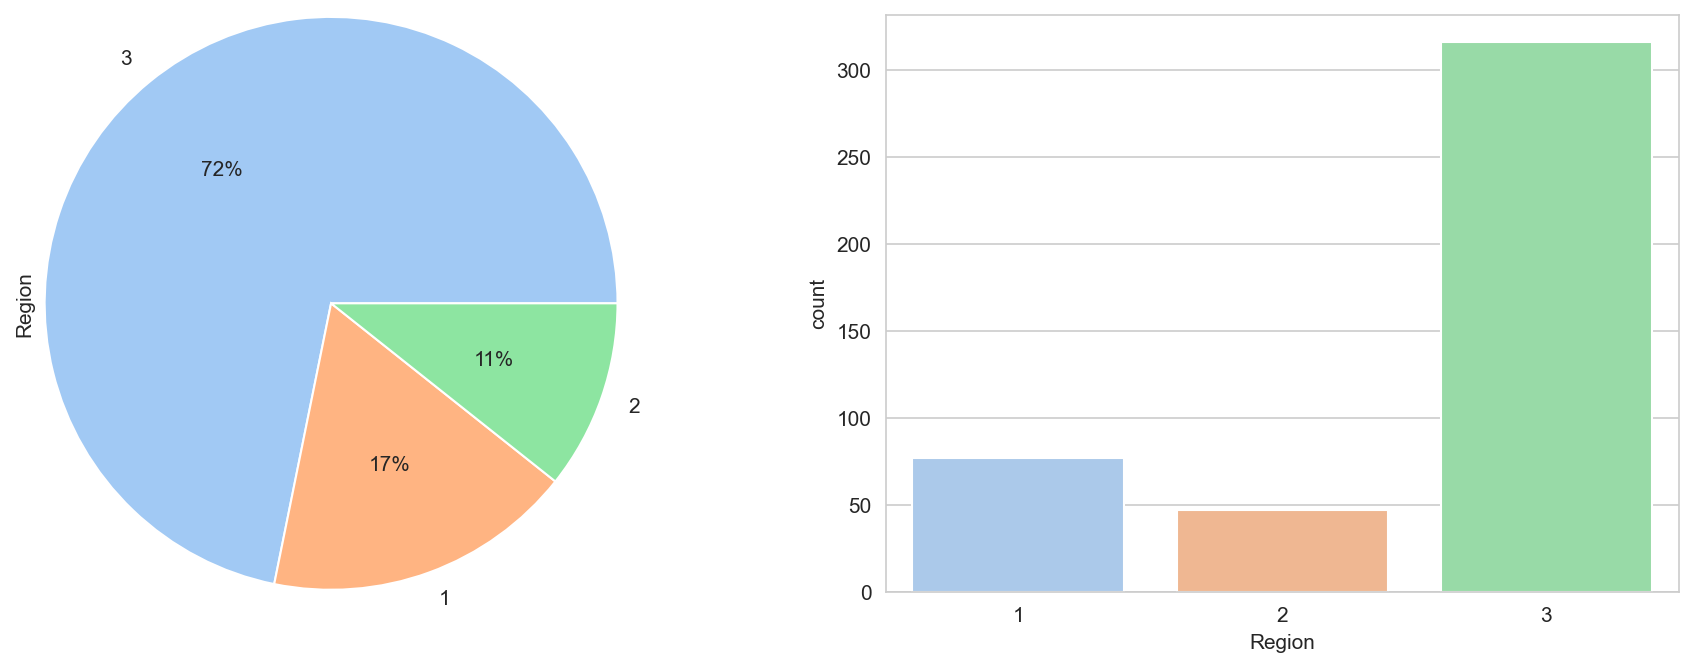

In [12]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5), dpi=150)
plt.subplot(121)
df['Region'].value_counts().plot(kind='pie', autopct='%2.f%%', radius=1.24, colors=sns.color_palette('pastel'))
plt.subplot(122)
sns.countplot(data=df, x='Region', palette='pastel')
df['Region'].value_counts()

## Sayısal Değişkenler

In [13]:
# kategorik verileri düşürelim
df.drop(['Region', 'Channel'], axis = 1, inplace=True)

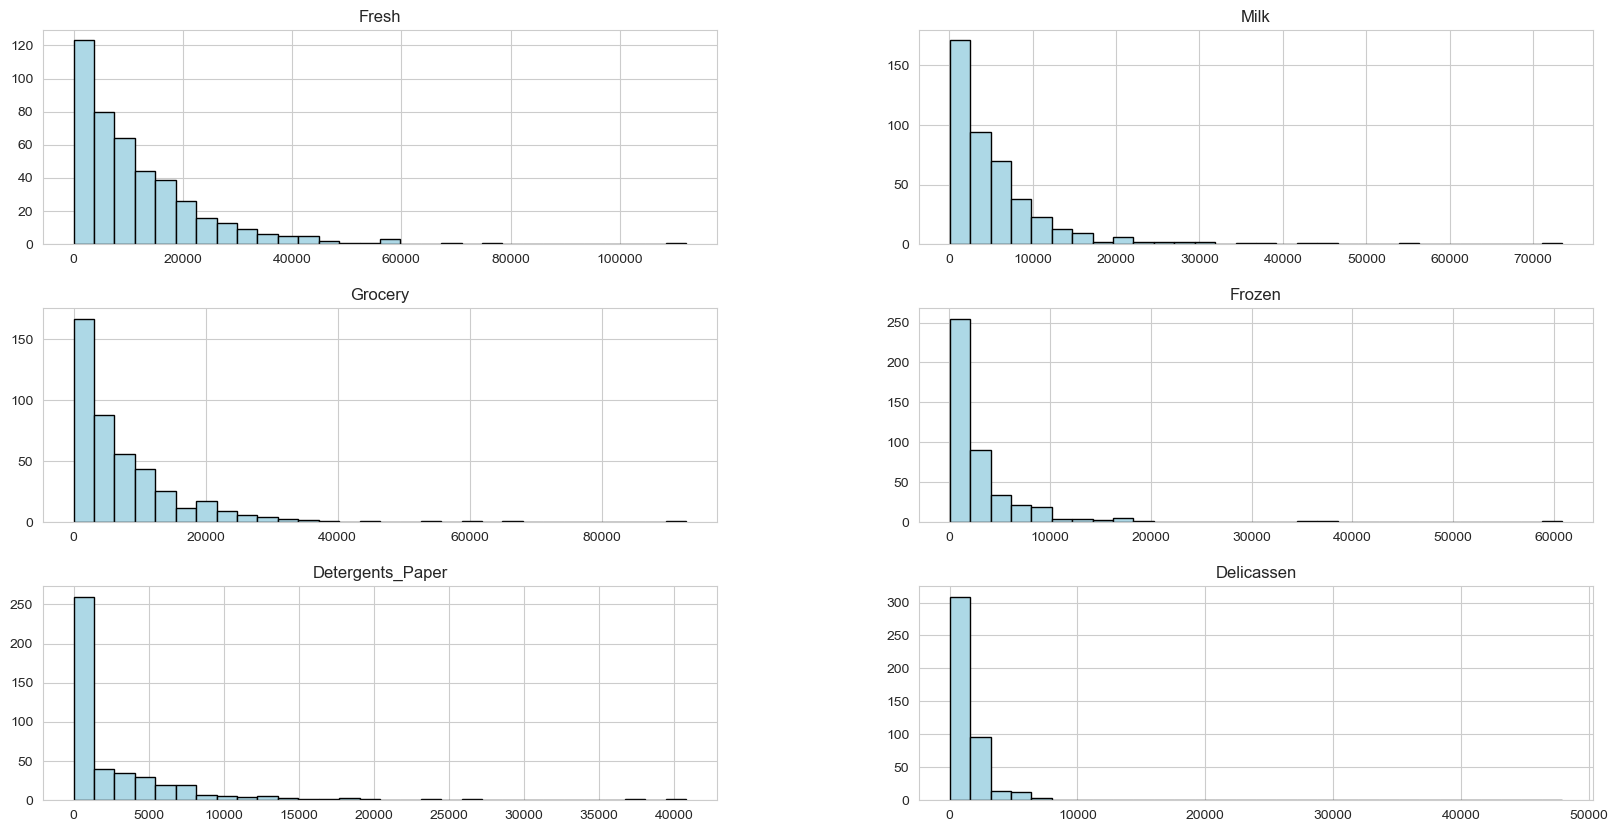

In [14]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

**Bu çıktıdan sürekli değişkenlerin dağılımlarının oldukça çarpık olduğu ve aykırı değerlerin olabileceği sonucunu çıkarabiliriz.**

## Çarpıklık-Basıklık

In [15]:
skewness = df.skew()
kurtosisness = df.kurtosis()

headers = ['Değişken', 'Shapiro Testi', 'Çarpıklık Katsayısı', 'Çarpıklık', 'Basıklık Katsayısı', 'Basıklık']

table_data = []
for col in df.columns:
    stat, p = normaltest(df[col])
    normal_dist = 'Evet' if p >= 0.05 else 'Hayır'
    skewness_val = f'{skewness[col]:.4f}'
    skewness_desc = 'Yüksek çarpıklık' if skewness[col] < -1 or skewness[col] > 1 else 'Simetrik veya hafif çarpık'
    kurtosis_val = f'{kurtosisness[col]:.4f}'
    kurtosis_desc = 'Çok basık veya sivri' if kurtosisness[col] < -2 or kurtosisness[col] > 2 else 'Normal veya hafif basık'

    stat_sh, p_sh = shapiro(df[col])
    shapiro_test = 'Evet' if p_sh >= 0.05 else 'Hayır'
    
    table_data.append([col, shapiro_test, skewness_val, skewness_desc, kurtosis_val, kurtosis_desc])

table = tabulate(table_data, headers, tablefmt='pretty')
print(table)

+------------------+---------------+---------------------+------------------+--------------------+----------------------+
|     Değişken     | Shapiro Testi | Çarpıklık Katsayısı |    Çarpıklık     | Basıklık Katsayısı |       Basıklık       |
+------------------+---------------+---------------------+------------------+--------------------+----------------------+
|      Fresh       |     Hayır     |       2.5613        | Yüksek çarpıklık |      11.5364       | Çok basık veya sivri |
|       Milk       |     Hayır     |       4.0538        | Yüksek çarpıklık |      24.6694       | Çok basık veya sivri |
|     Grocery      |     Hayır     |       3.5874        | Yüksek çarpıklık |      20.9147       | Çok basık veya sivri |
|      Frozen      |     Hayır     |       5.9080        | Yüksek çarpıklık |      54.6893       | Çok basık veya sivri |
| Detergents_Paper |     Hayır     |       3.6319        | Yüksek çarpıklık |      19.0095       | Çok basık veya sivri |
|    Delicassen    |    

In [16]:
normality=pd.DataFrame(index=['p-value', 'test-statistic'])
for i in df.columns:
    normality[i]=shapiro(df[i])
    
normality.T   

,p-value,test-statistic
Fresh,0.781436,7.918438e-24
Milk,0.628334,9.762062e-30
Grocery,0.676230,3.906127e-28
Frozen,0.528297,1.291332e-32
Detergents_Paper,0.605482,1.914593e-30
Delicassen,0.361068,1.753408e-36


Dağılımlar fazlasıyla çarpık ve basıktırlar. Eğer bu şekilde kümeleme yaparsak, değişkenlerdeki çarpık değerler uzaklık ölçümlerinde aşırı sonuçlar doğurabilir. Böyle bir sonuç istemediğimizden dolayı verilerin logaritmasını alacağız. Bu işlem, verilerin dağılımını daha simetrik hale getirebilir ve kümeleme sonuçlarını iyileştirebilir.

Verileri logaritmik bir ölçeğe getirmeden önce dikkat edilmesi gereken hususlar:
1. Logaritmik donüşüm özellikle sağ çarpık veriler için etkilidir.
2. Veri setinde sıfır ve negatif değerler bulunmamalı. 
3. Veri setindeki değişkenlerin aynı öneme sahip olduğu durumlarda daha dengeli sonuçlar verebilir. 

In [17]:
# logaritmik donusum
df = np.log(df)

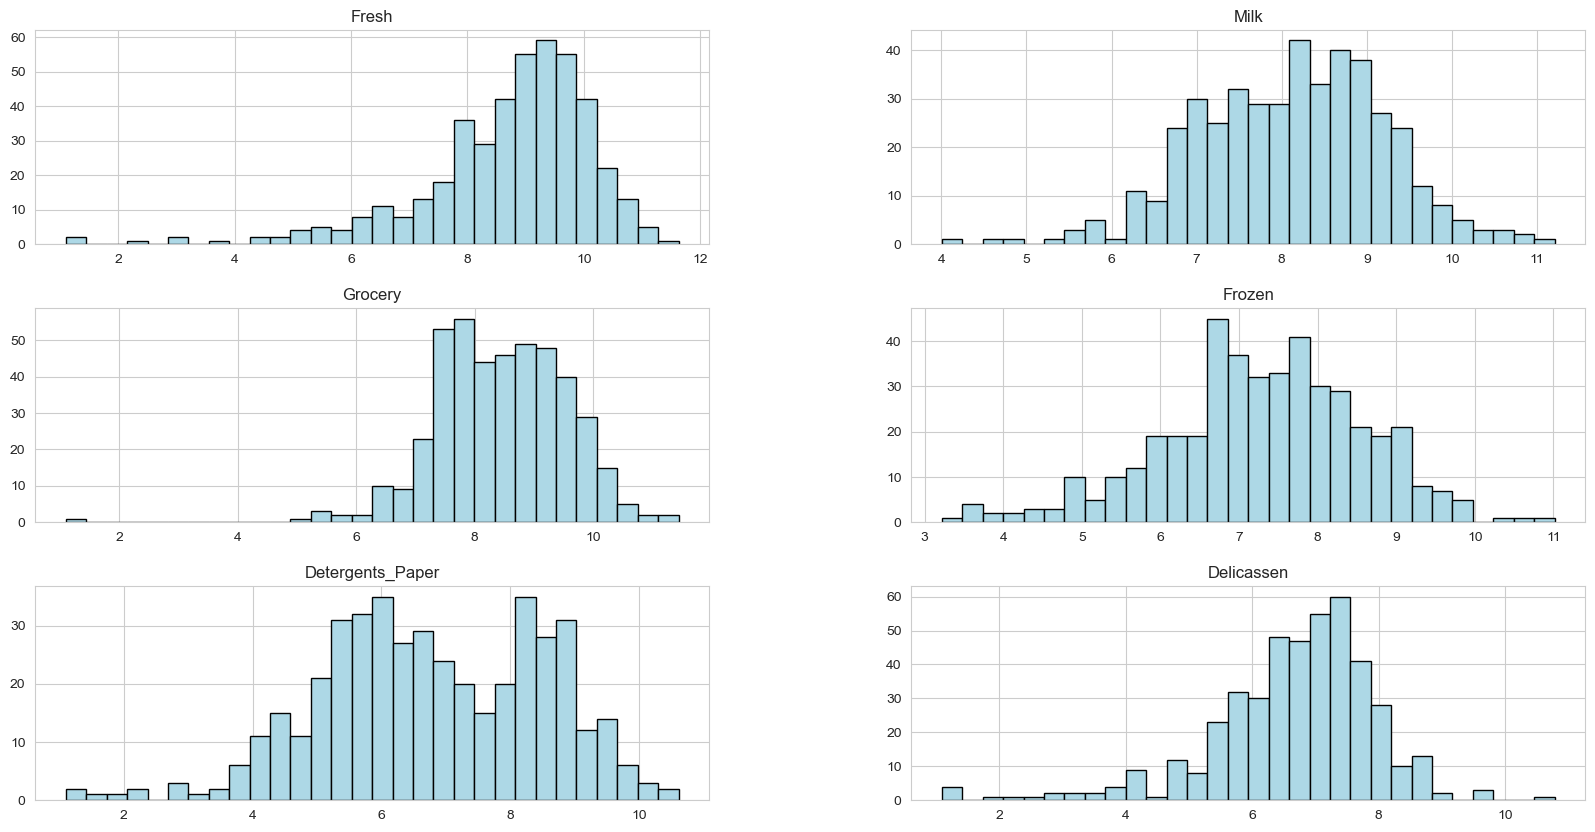

In [18]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

**Dönüşümden sonra verilerin daha dengeli bir hale geldiği söylenebilir.**

## Normal Dağılım Kontrolü

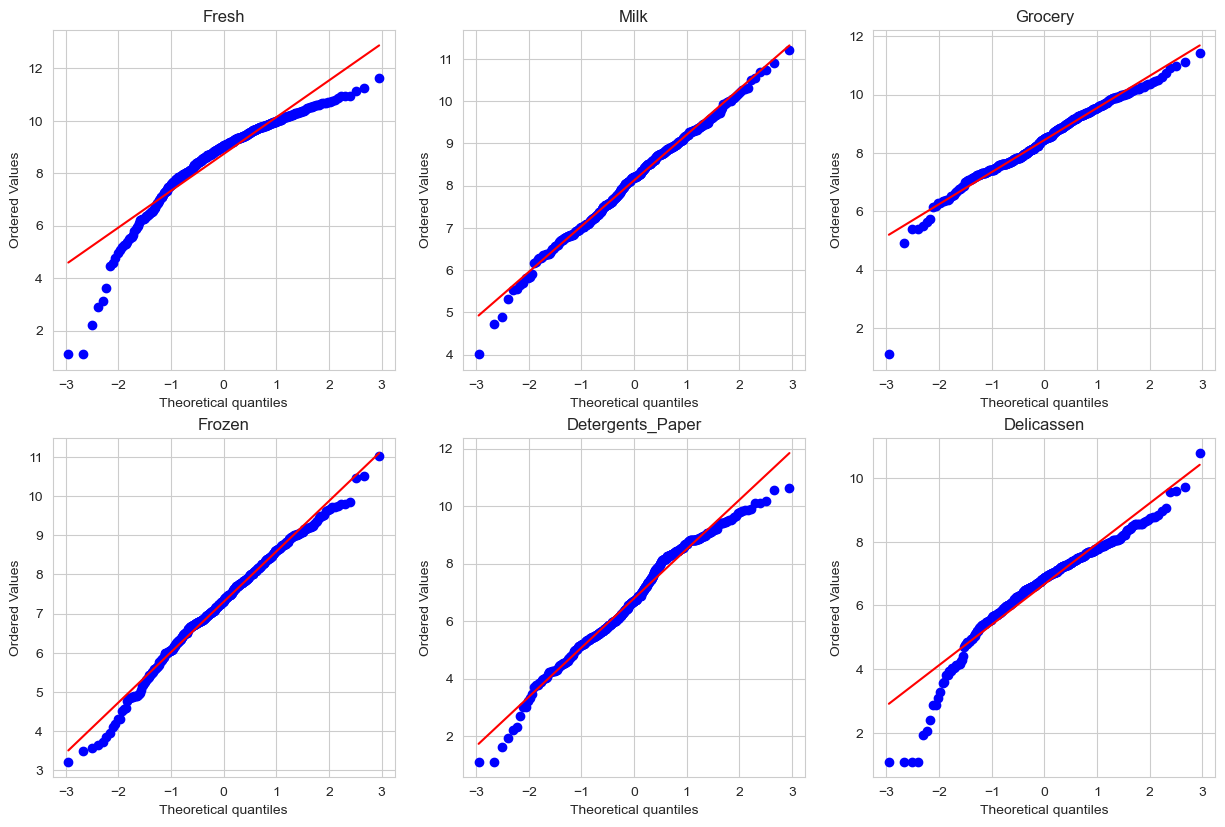

In [19]:
plt.figure(figsize=(15,15))
for i,var in enumerate(df.columns):
    plt.subplot(3,3,i+1)
    probplot(df[var], plot=plt)
    plt.title(f'{var}')
plt.show()  

Değişkenler genel olarak normal dağılımı yakalamışlar. Bu çıktıdan veri setinde aykırı değerler olabileceğini sezebiliyoruz.

Özellikle Fresh ve Delicassen değişkenlerinde aykırı değerler var gibi duruyor.

## Değişkenlik

<Axes: >

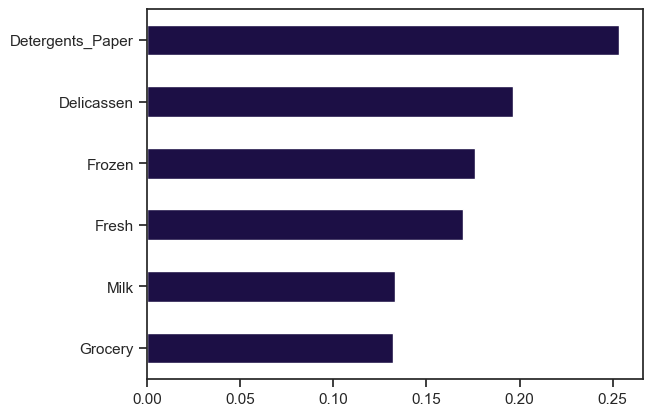

In [39]:
degiskenlik_katsayisi = df.std() / df.mean()
sirali_dk = degiskenlik_katsayisi.sort_values()
sirali_dk.plot.barh(x = 'Değişkenler', y = 'Değişkenlik Katsayısı', color = '#1c0f45')

## Box Plots

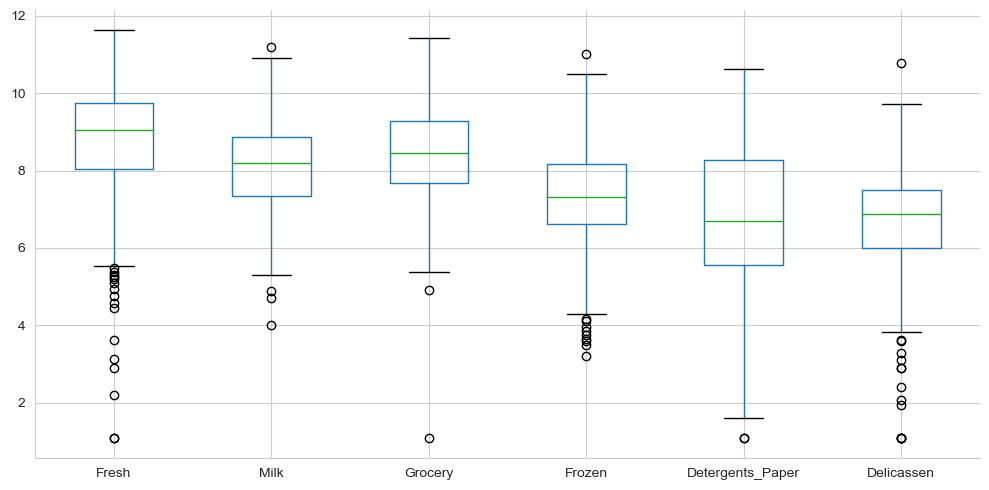

In [20]:
plt.figure(figsize=(10, 5))
df.boxplot()
sns.despine()
plt.tight_layout()
plt.show()

## Korelasyon

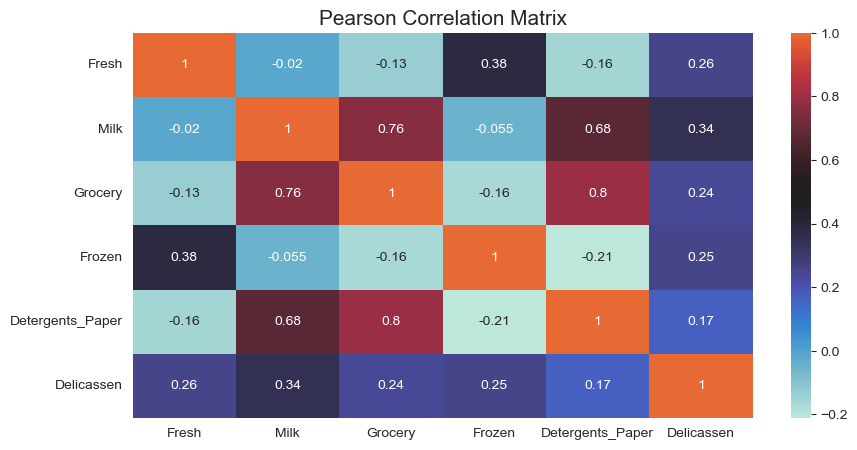

In [21]:
corr=df.corr()
plt.figure(figsize=(10,5))
plt.title('Pearson Correlation Matrix',fontsize=15)
sns.heatmap(corr, center=0.5,annot=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

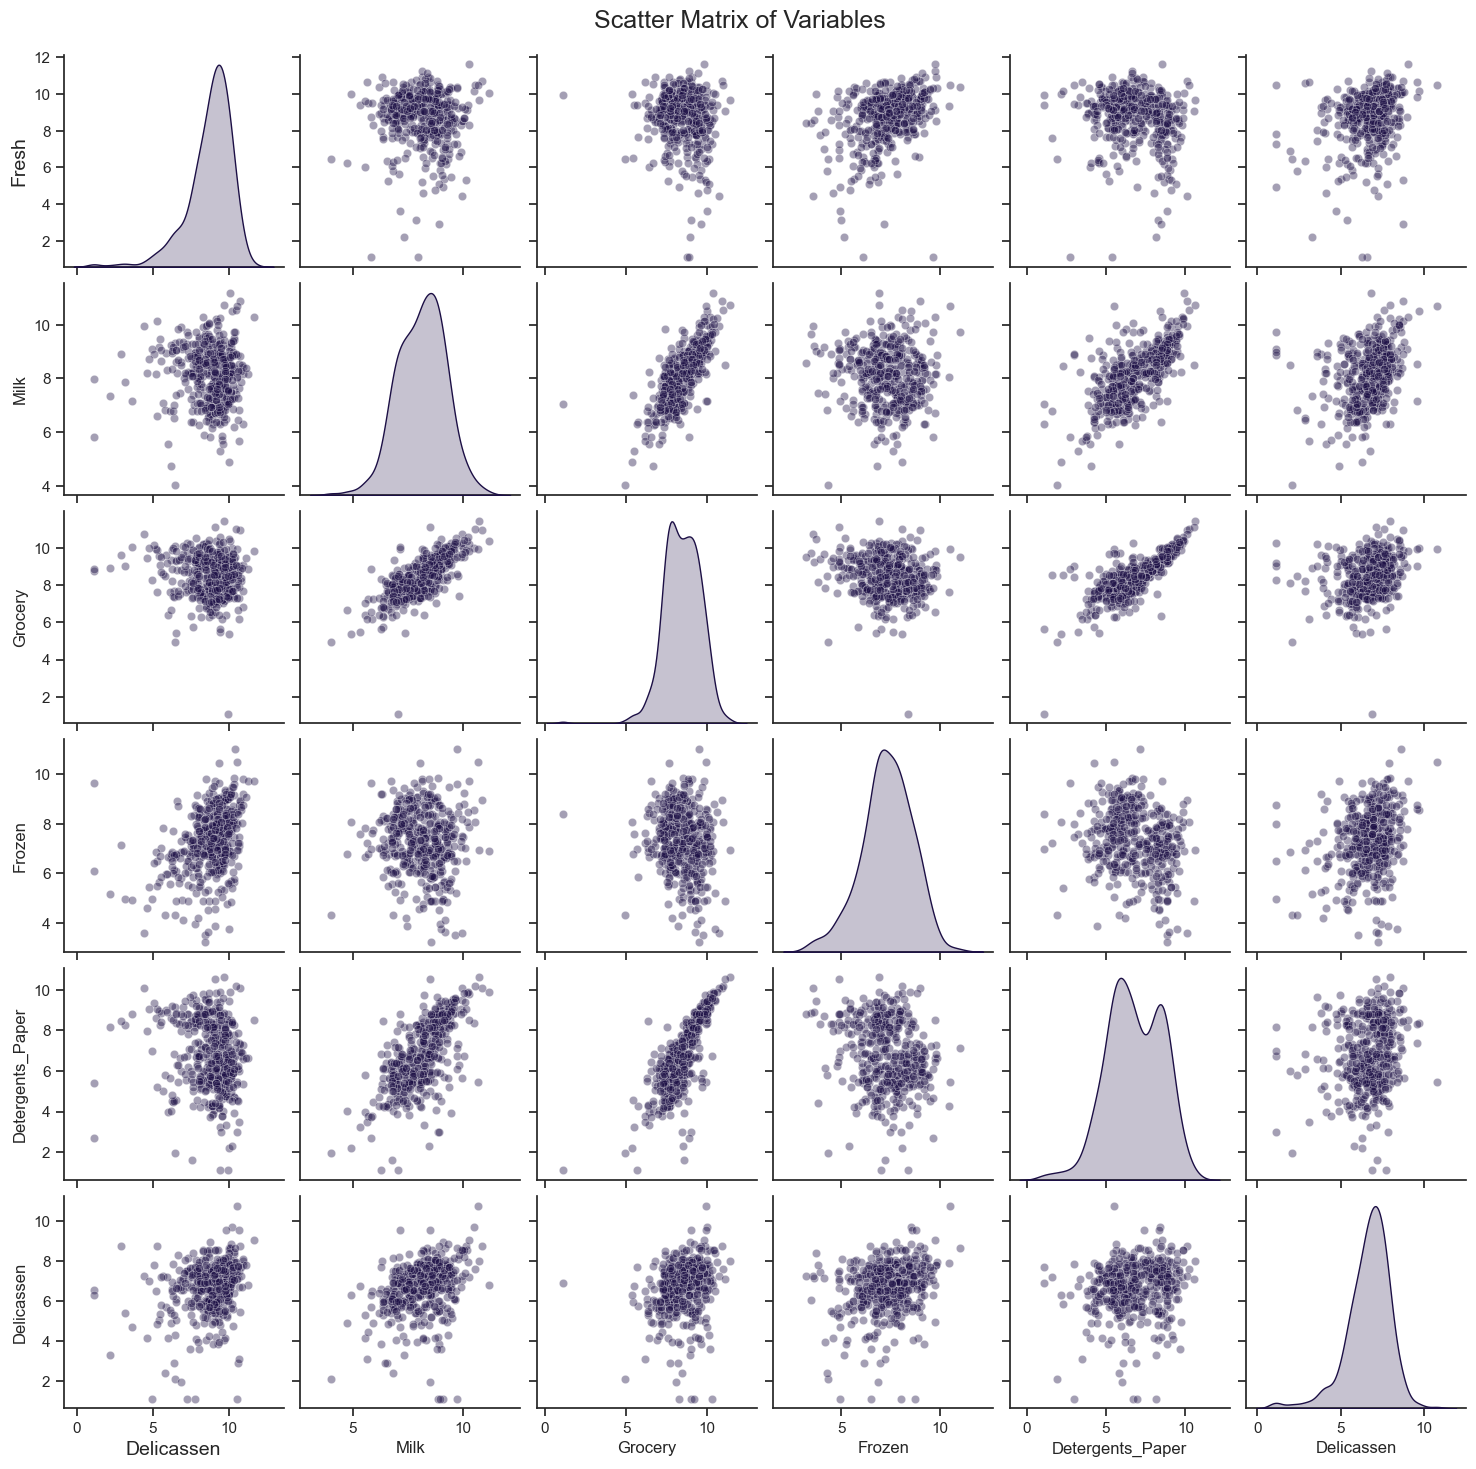

In [35]:
custom_palette = sns.color_palette(['#1c0f45'])
sns.set(style='ticks', palette=custom_palette) 
scatter_matrix = sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha': 0.4})
plt.subplots_adjust(top=0.95)  
scatter_matrix.fig.suptitle('Scatter Matrix of Variables', fontsize=18)  
scatter_matrix.axes[0, 0].set_ylabel(df.columns[0], fontsize=14)  
scatter_matrix.axes[-1, 0].set_xlabel(df.columns[-1], fontsize=14)  
plt.show()

## Scatter Plots

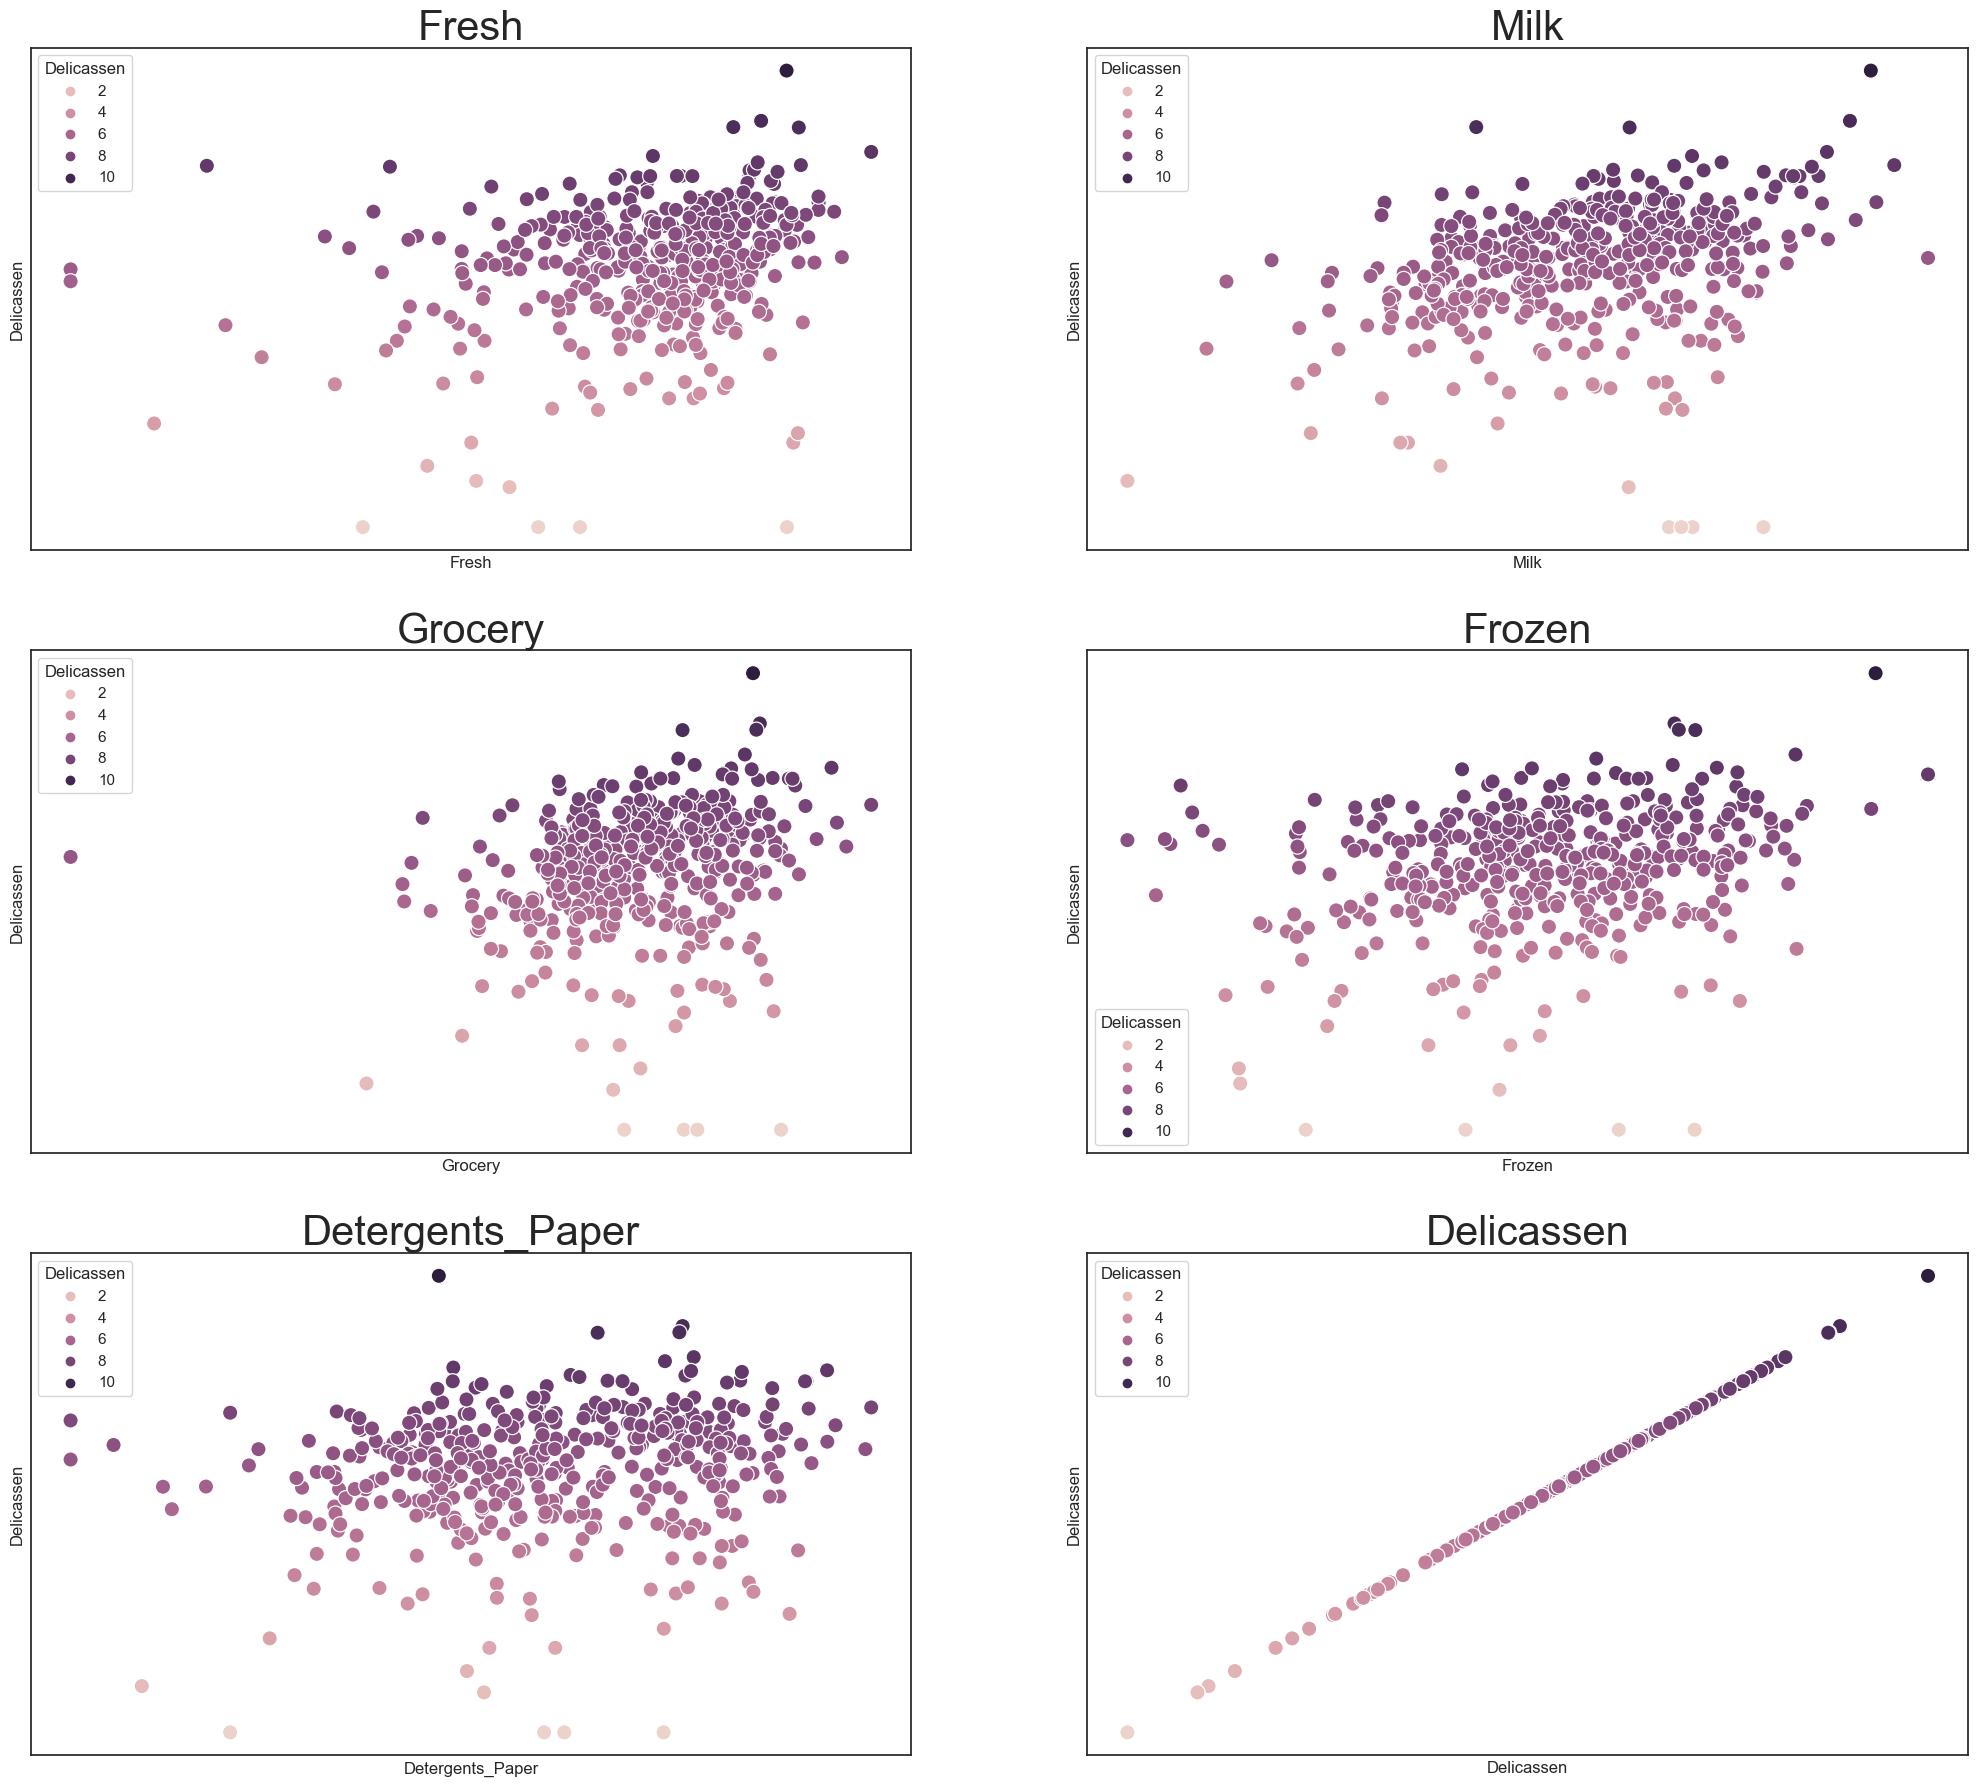

In [36]:
fig = plt.figure(figsize=(25, 30))

for i, column in enumerate(df.columns):
    ax = fig.add_subplot(4, 2, i + 1)
    sns.scatterplot(data=df, x=column, y='Delicassen', hue='Delicassen', ax=ax, s=120)
    ax.set_title(column, fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# 💹 Veri Ön İşleme

### Aykırı Gözlem Analizi

Aykırı gözlemleri belirleyelim ve baskılama yöntemini kullanarak bu değerleri alt ve üst sınıra eşitleyelim.

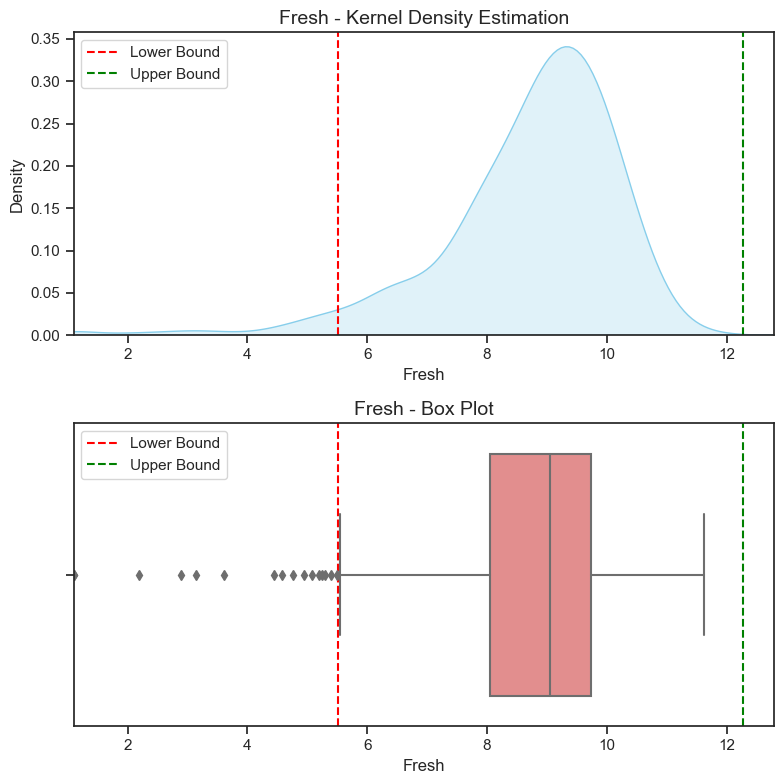

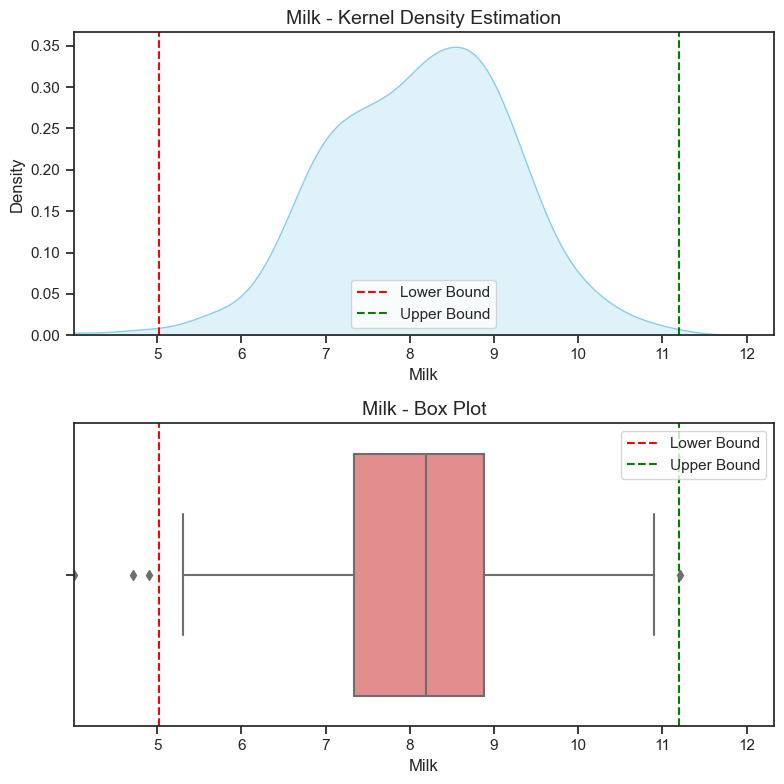

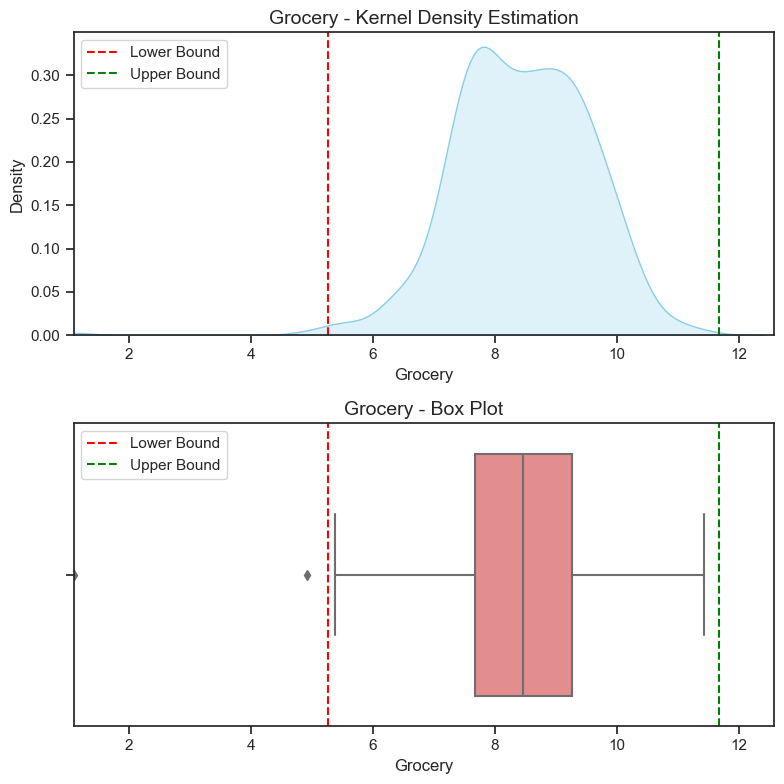

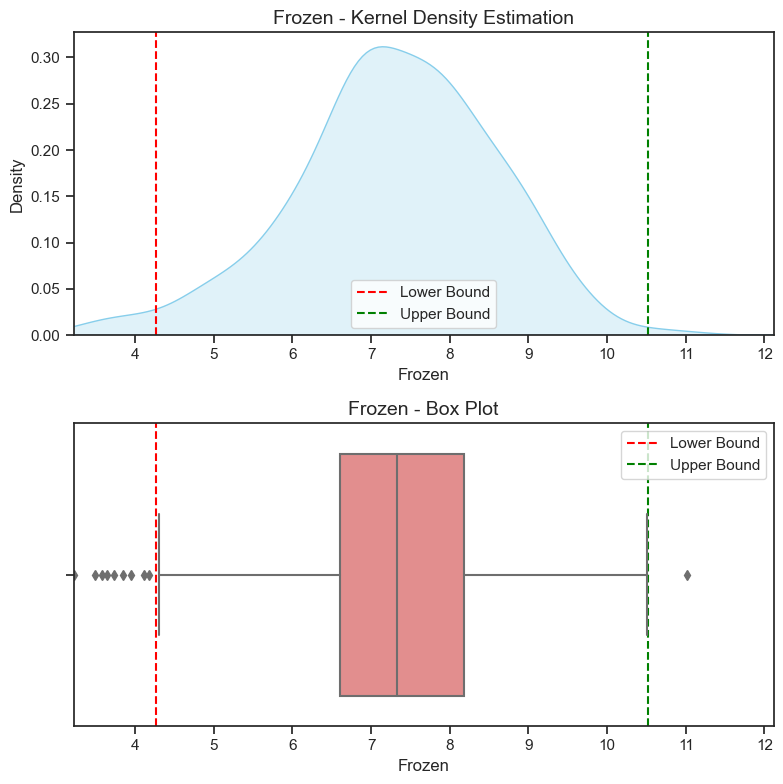

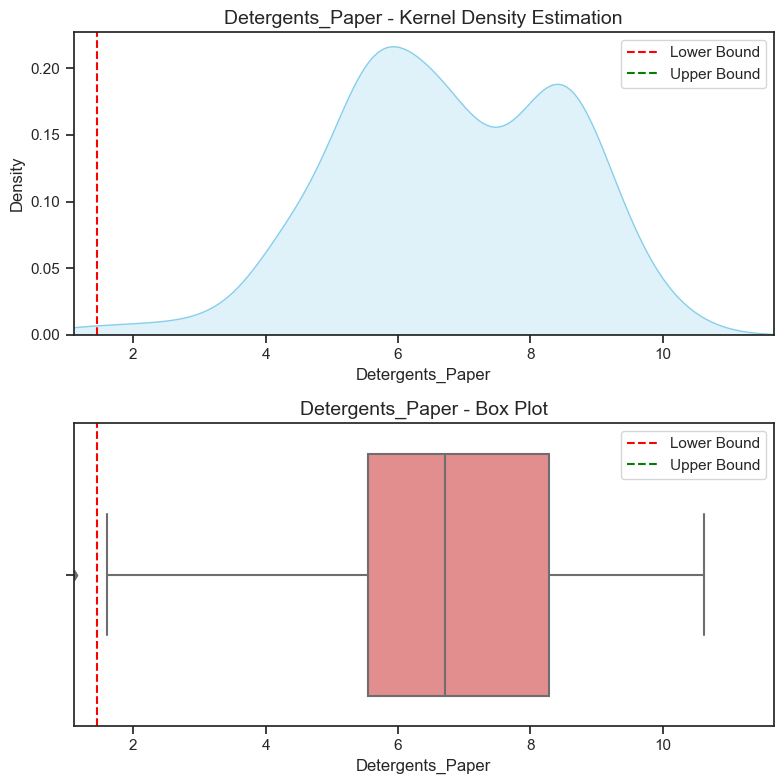

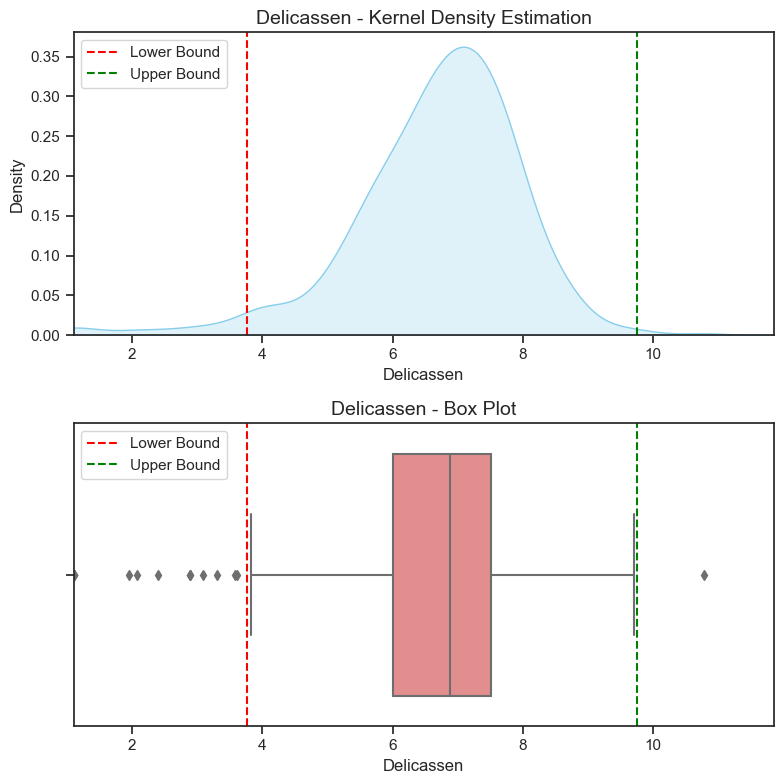

In [40]:
for i in df.keys():
    q25, q75 = np.percentile(df[i], [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - iqr * 1.5
    upper_bound = q75 + iqr * 1.5

    plt.figure(figsize=(8, 8))

    plt.subplot(211)
    plt.xlim(df[i].min(), df[i].max() * 1.1)
    plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound')
    sns.kdeplot(data=df[i], fill=True, color='skyblue')
    plt.legend()
    plt.title(f'{i} - Kernel Density Estimation', fontsize=14)
    
    plt.subplot(212)
    plt.xlim(df[i].min(), df[i].max() * 1.1)
    plt.axvline(x=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound')
    sns.boxplot(x=df[i], color='lightcoral')
    plt.legend()
    plt.title(f'{i} - Box Plot', fontsize=14)
    
    plt.tight_layout() 
    plt.show()

In [43]:
for i in df.keys():
    q25, q75 = np.percentile(df[i], [25,75])
    iqr = q75 - q25
    
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    
    df.loc[df[i] < lower_bound, i] = lower_bound
    df.loc[df[i] > upper_bound, i] = upper_bound

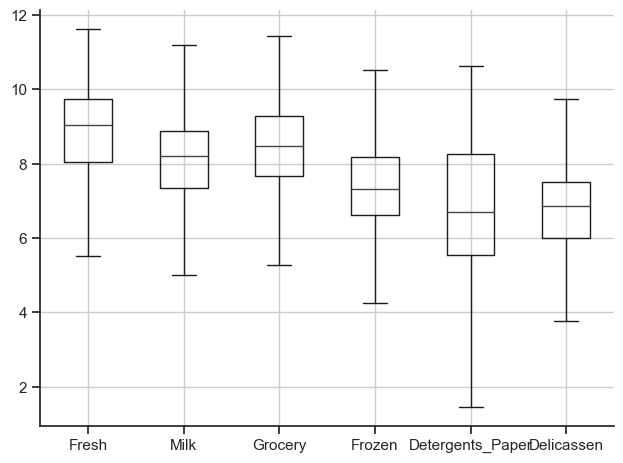

In [49]:
df.boxplot()
sns.despine()
plt.tight_layout()
plt.show()

### Tekrarlı ve Eksik Gözlem Analizi

In [46]:
# eksik gozlem var mi
df.isnull().sum()

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [45]:
# tekrarli satir var mi
df.duplicated().sum()

0

## Standartlaştırma

Kümeleme yapacağımızdan dolayı değerlerin birbirlerine olan uzaklıkları önemli. Bu bağlamda verileri standart bir ölçeğe getirerek değişkenlerin ölçüldüğü birimlerin veya değer aralıklarının etkisinin yaratacağı farkı azaltabiliriz.

In [51]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

# 🧠 Model

K-means alogoritmasında, küme sayısı önceden belirlenmelidir. Bu bağlamda uygun küme sayısını belirlemek için hiyerarşik yöntemleri kullanarak dendogram çizdireceğiz. Dendogram ile küme uygun küme sayısını sezgisel olarak görebiliriz.

Birbirleri içinde homojen ve diğer gruplar ile heterojen yapılar oluşturmak için ise hiyerarşik olmayan kümeleme yöntemlerini kullanacağız.

### Dendogram

Veri setindeki değişkenler sayısal verilerden oluştuğu için (kategoerik verileri dahil etmedik) Öklid uzaklığını kullanacağız.

In [64]:
euclidean_distances = pdist(df, metric='euclidean')
cluster_hierarchy = linkage(euclidean_distances, method='average')
observation_names = np.arange(0, df.shape[0]).tolist()

Text(0.5, 1.0, 'Veri Setinin Hiyerarşik Kümeleme Dendrogramı')

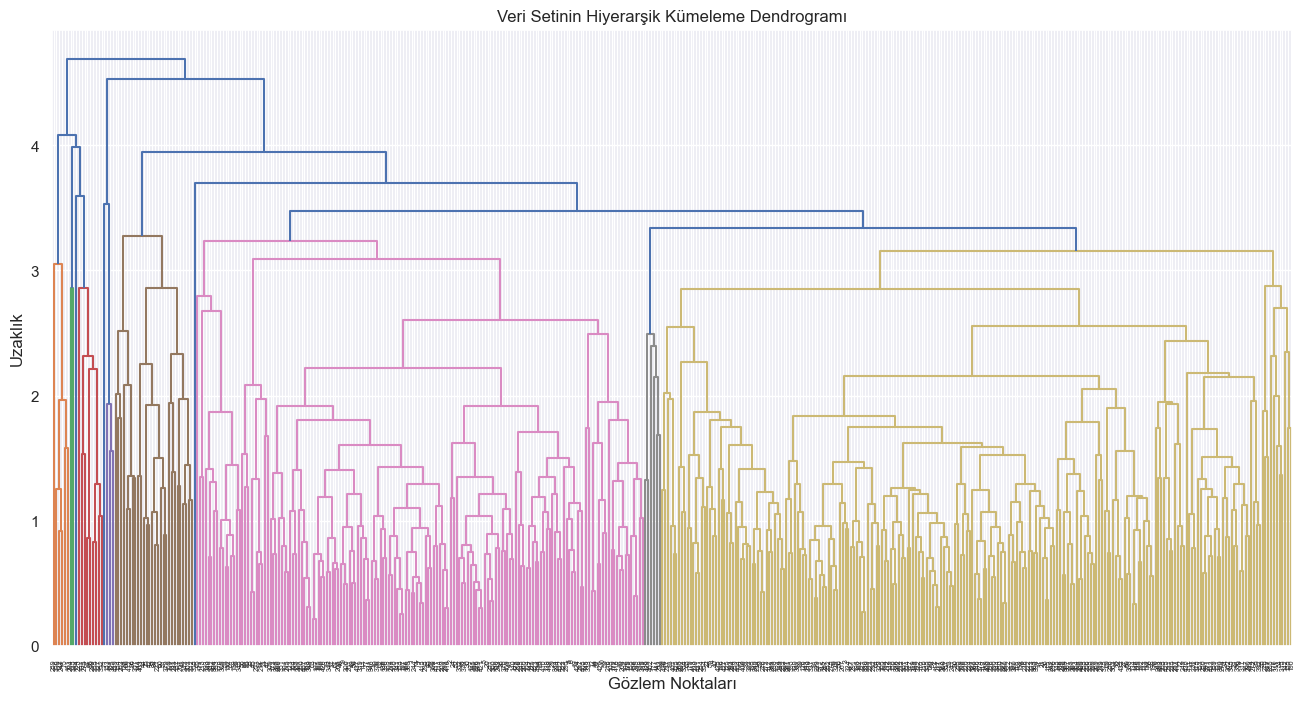

In [70]:
plt.figure(figsize=(16, 8))
dendrogram(clus,labels=observation_names)
plt.xlabel('Gözlem Noktaları')
plt.ylabel('Uzaklık')
plt.title('Veri Setinin Hiyerarşik Kümeleme Dendrogramı')

## K-Means Clustering

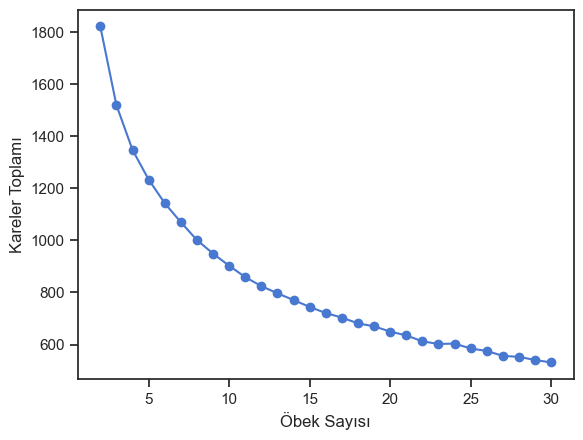

In [53]:
heap= 30
result = []
silhouette = []

for n in np.arange(2, heap+1):
    model = KMeans(n_clusters=n)
    model.fit(df)
    result.append(model.inertia_)
    prediction = model.predict(df)
    score = silhouette_score(df, prediction, metric='euclidean')
    silhouette.append(score)
    
plt.plot(np.arange(2, heap+1), result, 'bo-')
plt.xlabel('Öbek Sayısı')
plt.ylabel('Kareler Toplamı')
plt.show()

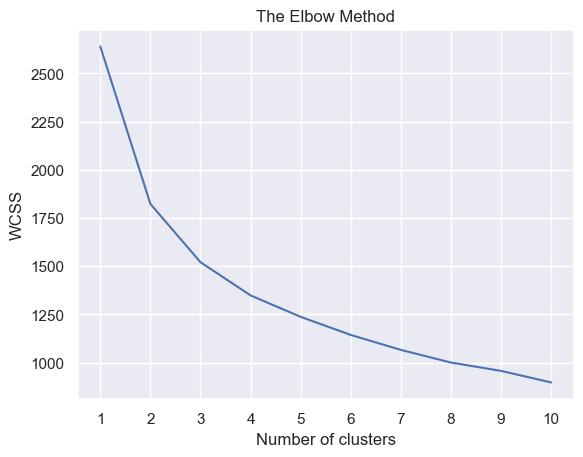

In [54]:
sns.set()
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', 
                    max_iter = 300,
                    n_init=10)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xticks(ticks=range(1, 11))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()